In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
from tensorflow.keras.layers import (Input, Embedding, Conv1D, GlobalMaxPooling1D,
                                     Bidirectional, LSTM, Dense, Dropout, concatenate,MaxPooling1D,Attention,Add,Flatten,LayerNormalization,GlobalAveragePooling1D,ZeroPadding1D)
from tensorflow.keras.models import Model
from keras.src.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Lambda

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
from tensorflow import keras
from collections import Counter
from tensorflow.keras.metrics import AUC, Precision, Recall

import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
import transformers



In [5]:
device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")

print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")


Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


In [6]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 2


In [7]:
strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

Number of devices: 2


In [24]:
df = pd.read_csv(r'/kaggle/input/cvefixes5/ShortCVE.csv')

In [26]:
lengths = df["code"].apply(len)
print(lengths.describe())


count     18509.000000
mean      40570.682857
std       71604.164255
min           8.000000
25%        5704.000000
50%       17765.000000
75%       45708.000000
max      966113.000000
Name: code, dtype: float64


In [27]:
df.head(5)

,Unnamed: 0,code,language,safety
0,0,package org.bouncycastle.jcajce.provider.asymm...,1,1
1,1,<?php\n\n\n\n/**\n\n * ownCloud - user_ldap\n\...,3,1
2,2,#!/usr/bin/env python\n\nfrom __future__ impor...,4,0
3,3,/* -*- c-basic-offset: 8 -*-\n\n rdesktop: A...,0,0
4,6,/*\n\n ettercap -- GTK+ GUI\n\n\n\n Copy...,0,1


In [28]:
df = df.drop(['Unnamed: 0'],axis=1)

In [29]:

# # Loop over a few sample rows to see a side-by-side comparison
# for index, row in df.sample(5).iterrows():
#     print("Row index:", index)
#     print("Vulnerable Code:\n", row[1])
#     print("Safe code:\n", row[0])
#     print("-" * 40)


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18509 entries, 0 to 18508
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   code      18509 non-null  object
 1   language  18509 non-null  int64 
 2   safety    18509 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 433.9+ KB


In [31]:
df.isna().sum()

code        0
language    0
safety      0
dtype: int64

In [32]:
df.describe()

,language,safety
count,18509.000000,18509.000000
mean,1.475444,0.500027
std,1.514323,0.500014
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,3.000000,1.000000
max,4.000000,1.000000


In [33]:

df.shape

(18509, 3)

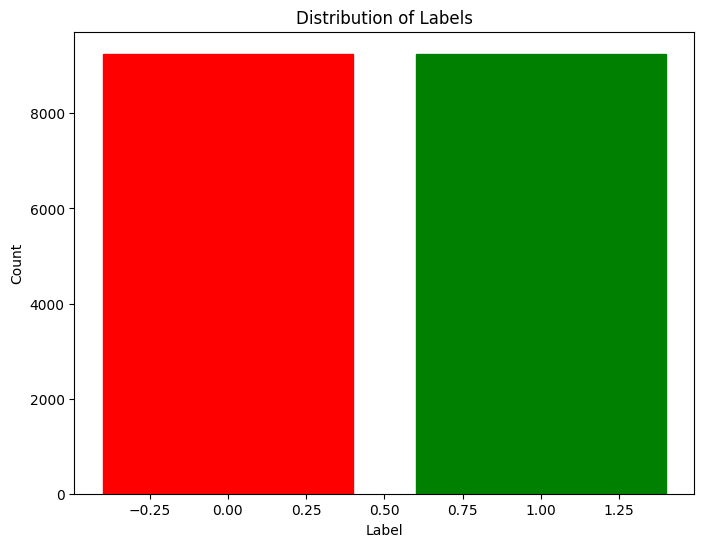

In [34]:



# Assuming 'label' column exists in your DataFrame 'df'

# Count the occurrences of each label
label_counts = df['safety'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values)

# Set colors for bars
bars[0].set_color('green')  # Color for label 0
bars[1].set_color('red')   # Color for label 1

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()


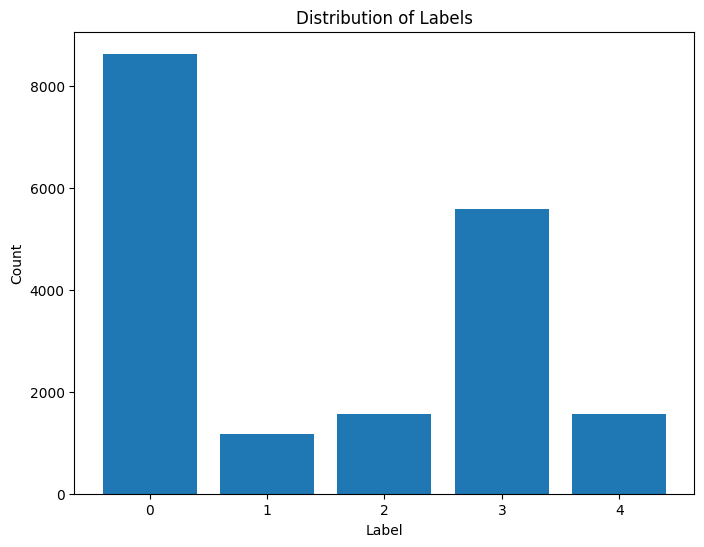

In [35]:



# Assuming 'label' column exists in your DataFrame 'df'

# Count the occurrences of each label
label_counts = df['language'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values)



plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()


In [36]:
from datasets import Dataset

In [37]:
#Converting the Pandas Dataframe to a HF dataset
dataset = Dataset.from_pandas(df)

**Tokenization Process**

In [38]:
def sliding_window_text(code_str, window_size=5000, step_size=2500):
    """
    Splits a code string into overlapping segments using a sliding window.
    
    :param code_str: The entire code as a string.
    :param window_size: Number of characters per window.
    :param step_size: How far to move between windows.
    :return: A list of overlapping code snippets.
    """
    snippets = []
    length = len(code_str)
    
    # If shorter than the window, just return the whole snippet
    if length <= window_size:
        return [code_str]
    
    # Move the window in increments of step_size
    start = 0
    while start < length - window_size + 1:
        snippet = code_str[start:start + window_size]
        snippets.append(snippet)
        start += step_size
    
    # Optionally, include the last window if it doesn't perfectly align
    if start < length:
        # If you want the last chunk to be exactly window_size in length:
        # snippets.append(code_str[-window_size:])
        
        # Or if you want a shorter trailing snippet:
        snippets.append(code_str[start:])
    
    return snippets


In [39]:
def sliding_map_function(batch):
    """
    batch: dict of lists for keys "code", "language", "safety"
    Returns expanded lists of code, language, safety with each snippet as a new example.
    """
    new_codes = []
    new_langs = []
    new_safeties = []
    
    # We'll iterate over each item in the batch
    for code_str, lang, safe in zip(batch["code"], batch["language"], batch["safety"]):
        # Apply the sliding window to the code string
        snippets = sliding_window_text(code_str, window_size=200, step_size=50)
        
        # Each snippet inherits the same language & safety labels
        for snippet in snippets:
            new_codes.append(snippet)
            new_langs.append(lang)
            new_safeties.append(safe)

    # Return lists with the same length
    return {
        "code": new_codes,
        "language": new_langs,
        "safety": new_safeties
    }


In [40]:
dataset_slid = dataset.map(
    sliding_map_function,
    batched=True,
    remove_columns=dataset.column_names  # remove original columns so we only keep new ones
)

# val_slid = val_dataset.map(
#     sliding_map_function,
#     batched=True,
#     remove_columns=val_dataset.column_names
# )

print("Train dataset after sliding window:")
print(dataset_slid)




Map:   0%|          | 0/18509 [00:00<?, ? examples/s]

Train dataset after sliding window:
Dataset({
    features: ['code', 'language', 'safety'],
    num_rows: 14973910
})


In [41]:
dataset_slid.shape

(14973910, 3)

In [42]:
data_half = dataset_slid[:20000]

In [43]:
dataset_half = Dataset.from_dict(data_half)

In [44]:
dataset_half.shape

(20000, 3)

In [45]:
print(dataset_half)

Dataset({
    features: ['code', 'language', 'safety'],
    num_rows: 20000
})


In [46]:
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

In [47]:
def tokenize_function(examples):
    # Tokenize the text with padding and truncation
    return tokenizer(examples['code'], 
                     padding='max_length',
                     max_length =512,
                     return_tensors='tf',
                     truncation=True)

# Apply the tokenizer to both the training and validation datasets
dataset_half = dataset_half.map(tokenize_function, batched=True)


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [48]:
# # Initialize CodeBERT AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [49]:
# from transformers import DistilBertTokenizerFast

# tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


In [50]:
# def tokenize_function(examples):
#     # Tokenize the text with padding and truncation
#     return tokenizer(examples['code'], 
#                      padding='max_length',
#                      max_length =512,
#                      return_tensors='tf',
#                      truncation=True)

# # Apply the tokenizer to both the training and validation datasets
# dataset = dataset.map(tokenize_function, batched=True)


In [62]:
# Split the dataset: 70% training, 30% validation
split_dataset = dataset_half.train_test_split(test_size=0.2,seed=42)

# Access training and validation datasets
train_dataset = split_dataset['train']
val_dataset = split_dataset['test']


In [63]:
train_dataset = train_dataset.shuffle(seed=42)
val_dataset = val_dataset.shuffle(seed=42)

In [64]:
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['code', 'language', 'safety', 'input_ids', 'attention_mask'],
    num_rows: 16000
})
Dataset({
    features: ['code', 'language', 'safety', 'input_ids', 'attention_mask'],
    num_rows: 4000
})


In [65]:
# train_tokenized = train_dataset.remove_columns(["code"])
# val_tokenized = val_dataset.remove_columns(["code"])

In [66]:
# train_tokenized.set_format("tf", columns=["input_ids", "attention_mask", "safety"])
# val_tokenized.set_format("tf", columns=["input_ids", "attention_mask", "safety"])

In [67]:
# # Convert each to a tf.data.Dataset
# batch_size = 2
# train_tf_dataset = train_tokenized.to_tf_dataset(
#     columns=["input_ids", "attention_mask"],
#     label_cols=["safety"],
#     shuffle=True,
#     batch_size=batch_size
# )
# val_tf_dataset = val_tokenized.to_tf_dataset(
#     columns=["input_ids", "attention_mask"],
#     label_cols=["safety"],
#     shuffle=False,
#     batch_size=batch_size
# )

In [68]:
# # Step 4: Load CodeBERT for sequence classification (TensorFlow version)
# from transformers import TFRobertaForSequenceClassification
# model = TFRobertaForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=2)

In [69]:
# # Step 5: Compile the model
# model.compile(
#     optimizer="adam",
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"]
# )

In [70]:
# # Step 6: Fine-Tune using the training and validation datasets
# model.fit(
#     train_tf_dataset,
#     validation_data=val_tf_dataset,
#     epochs=1
# )

In [71]:
train2= train_dataset

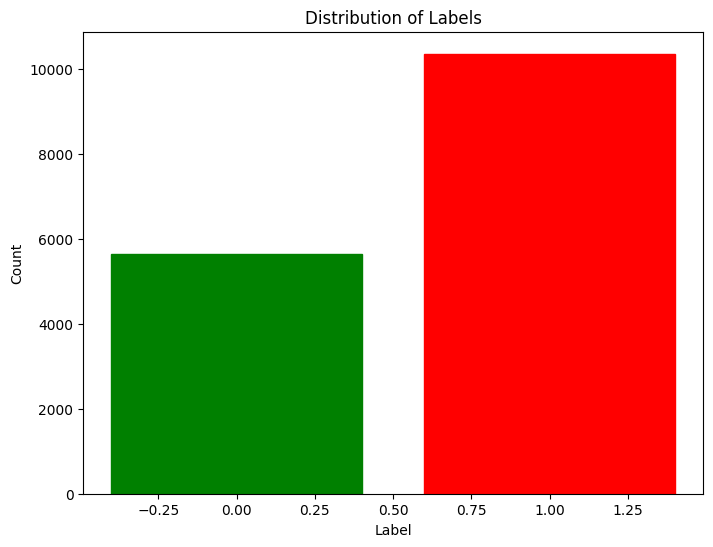

In [74]:

# Assuming 'label' column exists in your DataFrame 'df'
train_df = pd.DataFrame(train2)
# Count the occurrences of each label
label_counts = train_df['safety'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values)

# Set colors for bars
bars[0].set_color('red')  # Color for label 1
bars[1].set_color('green')   # Color for label 0

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()


In [75]:

print(label_counts)

safety
1    10351
0     5649
Name: count, dtype: int64


In [41]:
# # Shuffle the datasets separately
# train_dataset = train_dataset.shuffle(seed=42)
# val_dataset = val_dataset.shuffle(seed=42)


In [76]:
print('Train:', train_dataset.shape)
print('Val:', val_dataset.shape)

Train: (16000, 5)
Val: (4000, 5)


**Model Development**

In [77]:
# Convert 'input_ids' and 'labels' into NumPy arrays for training
X_train_input_ids = np.array(train_dataset['input_ids'])
X_train_attention_mask = np.array(train_dataset['attention_mask'])
y_train_lang=np.array(train_dataset['language'])
y_train_safety = np.array(train_dataset['safety'])

X_val_input_ids = np.array(val_dataset['input_ids'])
X_val_attention_mask = np.array(val_dataset['attention_mask'])
y_val_lang = np.array(val_dataset['language'])
y_val_safety = np.array(val_dataset['safety'])


In [78]:
# Check first 5 training samples
for i in range(5):
    print(f"Train Sample {i} input_ids length:", len(X_train_input_ids[i]))
    # print(f"Train Sample {i} attention_mask length:", len(X_train_attention_mask[i]))

# Check first 5 validation samples
for i in range(5):
    print(f"Val Sample {i} input_ids length:", len(X_val_input_ids[i]))
    # print(f"Val Sample {i} attention_mask length:", len(X_val_attention_mask[i]))

Train Sample 0 input_ids length: 512
Train Sample 1 input_ids length: 512
Train Sample 2 input_ids length: 512
Train Sample 3 input_ids length: 512
Train Sample 4 input_ids length: 512
Val Sample 0 input_ids length: 512
Val Sample 1 input_ids length: 512
Val Sample 2 input_ids length: 512
Val Sample 3 input_ids length: 512
Val Sample 4 input_ids length: 512


In [79]:
print("Train input_ids shape:", X_train_input_ids.shape)
print("Train attention_mask shape:", X_train_attention_mask.shape)
print("Train lang shape:", y_train_lang.shape)
print("Train safety shape:", y_train_safety.shape)

print()

print("Validation Input_ids shape:", X_val_input_ids.shape)
print("Validation attention_mask shape:", X_val_attention_mask.shape)
print("Validation lang shape:", y_val_lang.shape)
print("Validation safety shape:", y_val_safety.shape)



Train input_ids shape: (16000, 512)
Train attention_mask shape: (16000, 512)
Train lang shape: (16000,)
Train safety shape: (16000,)

Validation Input_ids shape: (4000, 512)
Validation attention_mask shape: (4000, 512)
Validation lang shape: (4000,)
Validation safety shape: (4000,)


In [81]:


# Select 5 random indices and inspect the corresponding entries
indices = np.random.choice(range(len(X_train_input_ids)), size=5, replace=False)
for i in indices:
    print("Sample #", i)
    print("Input:", X_train_input_ids[i])
    print("Label Languagae:", y_train_lang[i])
    print("Label Safety:", y_train_safety[i])
    


Sample # 13983
Input: [    0   417  1722  1215  8738  1215 14413  1640 18266   530  1215 44815
  4581    36 43735  2154   238 11045   530  1215 28974  1215 42740  1215
 31152  2076  4397 50140  1437  1437   821 37001  1215 42996  1215  8738
  1215  1535 38142  1640 18266   530  1215 44815  4581    36 43735  2154
   238 46007  4397 50140  1437  1437   821 37001  1215 48972  1215 12005
  1640 43735  2154  4397 50140 50140  1437  1437 48565    13 11045   530
     7  2332     5 25730   122 48404 50140  1437  1437  8401   718     2
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     

In [82]:
print("Unique language labels:", np.unique(y_train_lang))


Unique language labels: [0 1 2 3 4]


In [83]:
print("Unique language labels:", np.unique(y_train_safety))


Unique language labels: [0 1]


In [84]:
from transformers import TFRobertaModel

In [85]:
class CodeBertLayer(tf.keras.layers.Layer):
    
    def __init__(self, model_name="microsoft/codebert-base", **kwargs):
        super().__init__(**kwargs)
        self.codebert = TFRobertaModel.from_pretrained(model_name)
        self.codebert.trainable = True
    
    def call(self, inputs, **kwargs):
        input_ids, attention_mask = inputs
        # Ensure the input shapes are consistent
        tf.debugging.assert_equal(
            tf.shape(input_ids),
            tf.shape(attention_mask),
            message="Input IDs and Attention Mask must have the same shape!"
        )
        outputs = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # Shape: (batch_size, sequence_length, hidden_size)


In [86]:
# def model_architecture(max_length=512,num_neurons=64,device='cuda'):
#   #input layer
#   input_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
#   attention_mask = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

#   # Wrap DistilBert in a Lambda
#   bert_embedding = Lambda(distilbert_lambda,output_shape=(max_length, 768))([input_ids, attention_mask])


#   dropout_rate = 0.2
#   pool_size = 2
#   l2_reg=0.001
#   #CNN block:
#   cnn1 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same',)(bert_embedding)
#   cnn1 = MaxPooling1D(pool_size=pool_size)(cnn1)
#   cnn1 = BatchNormalization()(cnn1)
#   cnn1 = Dropout(dropout_rate)(cnn1)

#   cnn2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(cnn1)
#   cnn2 = MaxPooling1D(pool_size=pool_size)(cnn2)
#   cnn2 = BatchNormalization()(cnn2)
#   cnn2 = Dropout(dropout_rate)(cnn2)

#   cnn3 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(cnn2)
#   cnn3 = MaxPooling1D()(cnn3)
#   cnn3 = BatchNormalization()(cnn3)
#   #cnn3 = Attention()([cnn3,cnn3])
#   cnn3 = GlobalMaxPooling1D()(cnn3)
#   cnn3 = Dropout(dropout_rate)(cnn3)




#   #Bilstm block:
#   bilstm1 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bert_embedding)
#   #bilstm1 = BatchNormalization()(bilstm1)
#   bilstm1 = Dropout(dropout_rate)(bilstm1)
#   #bilstm1 = GlobalMaxPooling1D()(bilstm1)

#   bilstm2 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bilstm1)
#   #bilstm2 = BatchNormalization()(bilstm2)
#   bilstm2 = Dropout(dropout_rate)(bilstm2)


#   bilstm3 = Bidirectional(LSTM(num_neurons, return_sequences=False))(bilstm2)
#   bilstm3 = BatchNormalization()(bilstm3)
#   #bilstm3 = Attention()([bilstm3, bilstm3])
#   #bilstm3 = GlobalMaxPooling1D()(bilstm3)
#   bilstm3 = Dropout(dropout_rate)(bilstm3)





#   #Merging block(CNN+biLSTM):
#   merged = concatenate([cnn3, bilstm3])
#   merged = Dropout(dropout_rate)(merged)
#   #Dense block:
#   dense = Dense(64, activation='relu')(merged)
#   #dense = BatchNormalization()(dense)
#   dense = Dropout(dropout_rate)(dense)
#   output = Dense(1, activation='sigmoid')(dense)


#   #Compiling the model
#   optimizer = Adam(
#     learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
#             initial_learning_rate=0.0001,
#             decay_steps=1000,
#             decay_rate=0.95
#         ),
#     weight_decay=0.01
#   )


#   model = Model(inputs=[input_ids, attention_mask], outputs=output)
#   model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),
#             tf.keras.metrics.Recall(name='recall')])

#   return model




In [87]:
# def model_architecture(max_length=512,
#                 cnn_filters=162,
#                 num_neurons=250,
#                 dropout_rate=0.3,
#                 l2_reg=0.002,
#                 num_classes_language=5,
#                 num_classes_safety=2):
    
#     # Inputs for token ids and attention masks
#     input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
#     attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
    
#     # Obtain BERT embeddings
#     bert_embedding = DistilBertLayer()( [input_ids, attention_mask] )
    
#     # ====================
#     # CNN Block
#     # # ====================
#     cnn1 = Conv1D(filters=cnn_filters, kernel_size=3, padding='same',strides = 1, activation='relu')(bert_embedding)
#     cnn1 = MaxPooling1D(pool_size=2, padding='same')(cnn1)
#     cnn1 = BatchNormalization()(cnn1)
#     # cnn1 = Dropout(dropout_rate)(cnn1)
    
#     cnn2 = Conv1D(filters=cnn_filters, kernel_size=3, padding='same',strides=1, activation='relu')(cnn1)
#     cnn2 = MaxPooling1D(pool_size=2, padding='same')(cnn2)
#     cnn2 = BatchNormalization()(cnn2)
#     cnn2 = Dropout(dropout_rate)(cnn2)
#     cnn2 = GlobalAveragePooling1D()(cnn2)
    
#     # ====================
#     # BiLSTM Block
#     # ====================
#     bilstm1 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bert_embedding)
#     bilstm1 = LayerNormalization()(bilstm1)
#     bilstm1 = Dropout(dropout_rate)(bilstm1)
    
#     bilstm2 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bilstm1)
#     bilstm2 = LayerNormalization()(bilstm2)
#     bilstm2 = Dropout(dropout_rate)(bilstm2)
    

#     # bilstm3 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bilstm2)
#     # bilstm3 = LayerNormalization()(bilstm3)
#     # bilstm3 = Dropout(dropout_rate)(bilstm3)
    
#     # bilstm4 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bilstm3)
#     # bilstm4 = LayerNormalization()(bilstm4)
#     # bilstm4 = Dropout(dropout_rate)(bilstm4)
#     # bilstm4 = GlobalAveragePooling1D()(bilstm4)
    
#     # ====================
#     # Merge CNN and BiLSTM outputs
#     # ====================
#     attention = Attention()([bilstm2, bilstm2])
#     attention = GlobalMaxPooling1D()(attention)
#     merged = concatenate([cnn2, attention])
#     # merge = GlobalAverage1D()(merge)
#     # Fully connected layer for further processing
#     fc1 = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(merged)
#     fc1 = LayerNormalization()(fc1)
#     fc1 = Dropout(dropout_rate)(fc1)
    
#     # ====================
#     # Output Heads
#     # ====================
#     language_output = Dense(num_classes_language, activation='softmax', name='language_output')(fc1)

#     cnn3 = Conv1D(filters=cnn_filters, kernel_size=3, padding='same',strides = 1, activation='relu')(bert_embedding)
#     cnn3 = MaxPooling1D(pool_size=2, padding='same')(cnn3)
#     cnn3 = BatchNormalization()(cnn3)
#     # cnn1 = Dropout(dropout_rate)(cnn1)
    
#     cnn4 = Conv1D(filters=cnn_filters, kernel_size=3, padding='same',strides=1, activation='relu')(cnn3)
#     cnn4 = MaxPooling1D(pool_size=2, padding='same')(cnn4)
#     cnn4 = BatchNormalization()(cnn4)
#     cnn4 = Dropout(dropout_rate)(cnn4)
#     cnn4 = GlobalAveragePooling1D()(cnn4)

#     bilstm4 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bert_embedding)
#     bilstm4 = LayerNormalization()(bilstm4)
#     bilstm4 = Dropout(dropout_rate)(bilstm4)
    
#     bilstm5 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bilstm4)
#     bilstm5 = LayerNormalization()(bilstm5)
#     bilstm5 = Dropout(dropout_rate)(bilstm5)
    

#     # bilstm6 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bilstm5)
#     # bilstm6 = LayerNormalization()(bilstm6)
#     # bilstm6 = Dropout(dropout_rate)(bilstm6)
    
#     attention2 = Attention()([bilstm5, bilstm5])
#     attention2 = GlobalMaxPooling1D()(attention2)
#     merged2 = concatenate([cnn4, attention2])

#     fc2 = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(merged2)
#     fc2 = LayerNormalization()(fc2)
#     fc2 = Dropout(dropout_rate)(fc2)
    
#     # #Safety Dense
#     # safety_branch1 = Dense(128, activation='relu')(fc)
#     # safety_branch1 = LayerNormalization()(safety_branch1)
#     # # safety_branch1 = Dropout(dropout_rate)(safety_branch1)


#     safety_branch2 = Dense(128, activation='relu')(fc2)
#     safety_branch2 = LayerNormalization()(safety_branch2)
#     safety_branch2 = Dropout(dropout_rate)(safety_branch2)
#     safety_output = Dense(1, activation='sigmoid', name='safety_output')(safety_branch2)
    
    
    
#     model = Model(inputs=[input_ids, attention_mask], outputs=[language_output, safety_output])
    
#     # Define optimizer and compile the model
#     optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
#     model.compile(optimizer=optimizer,
#                   loss={'language_output': 'sparse_categorical_crossentropy',
#                         'safety_output': 'binary_crossentropy'},
#                   loss_weights={'language_output': 0.5, 'safety_output': 1.5},
#                     metrics={
#                         'language_output':'accuracy',
#                         'safety_output':['accuracy',AUC(), Precision(), Recall()]
#                     # 'safety_output':'ROC'
#                     }
#                  )
#     return model




In [88]:
def model_architecture(max_length=512,
                       cnn_filters=162,
                       num_neurons=250,
                       dropout_rate=0.3,
                       l2_reg=0.002,
                       num_classes_language=5,
                       num_classes_safety=2):
    
    # Inputs
    input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
    
    # BERT embeddings
    bert_embedding = CodeBertLayer()([input_ids, attention_mask])
    
    # ====================
    # Language Branch
    # ====================
    # CNN Block for language branch
    cnn1 = Conv1D(filters=cnn_filters, kernel_size=3, padding='same', strides=1, activation='relu')(bert_embedding)
    cnn1 = MaxPooling1D(pool_size=2, padding='same')(cnn1)
    cnn1 = BatchNormalization()(cnn1)
    
    cnn2 = Conv1D(filters=cnn_filters, kernel_size=3, padding='same', strides=1, activation='relu')(cnn1)
    cnn2 = MaxPooling1D(pool_size=2, padding='same')(cnn2)
    cnn2 = BatchNormalization()(cnn2)
    cnn2 = Dropout(dropout_rate)(cnn2)
    cnn2 = GlobalAveragePooling1D()(cnn2)
    
    # BiLSTM Block for language branch
    bilstm1 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bert_embedding)
    bilstm1 = LayerNormalization()(bilstm1)
    bilstm1 = Dropout(dropout_rate)(bilstm1)
    
    bilstm2 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bilstm1)
    bilstm2 = LayerNormalization()(bilstm2)
    bilstm2 = Dropout(dropout_rate)(bilstm2)
    
    # Attention on BiLSTM outputs
    attention = Attention()([bilstm2, bilstm2])
    attention = GlobalMaxPooling1D()(attention)
    
    merged_lang = concatenate([cnn2, attention])
    
    fc1 = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(merged_lang)
    fc1 = LayerNormalization()(fc1)
    fc1 = Dropout(dropout_rate)(fc1)
    
    # Language output (softmax for multi-class)
    language_output = Dense(num_classes_language, activation='softmax', name='language_output')(fc1)
    
    
    # ====================
    # Safety Branch (Dedicated)
    # ====================
    # CNN Block for safety branch
    cnn3 = Conv1D(filters=cnn_filters, kernel_size=3, padding='same', strides=1, activation='relu')(bert_embedding)
    cnn3 = MaxPooling1D(pool_size=2, padding='same')(cnn3)
    cnn3 = BatchNormalization()(cnn3)
    
    cnn4 = Conv1D(filters=cnn_filters, kernel_size=3, padding='same', strides=1, activation='relu')(cnn3)
    cnn4 = MaxPooling1D(pool_size=2, padding='same')(cnn4)
    cnn4 = BatchNormalization()(cnn4)
    cnn4 = Dropout(dropout_rate)(cnn4)
    cnn4 = GlobalAveragePooling1D()(cnn4)
    
    # BiLSTM Block for safety branch
    bilstm4 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bert_embedding)
    bilstm4 = LayerNormalization()(bilstm4)
    bilstm4 = Dropout(dropout_rate)(bilstm4)
    
    bilstm5 = Bidirectional(LSTM(num_neurons, return_sequences=True))(bilstm4)
    bilstm5 = LayerNormalization()(bilstm5)
    bilstm5 = Dropout(dropout_rate)(bilstm5)
    
    # Attention on safety BiLSTM outputs
    attention2 = Attention()([bilstm5, bilstm5])
    attention2 = GlobalMaxPooling1D()(attention2)
    
    # Merge the CNN and BiLSTM paths for safety
    merged_safe = concatenate([cnn4, attention2])
    
    fc2 = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(merged_safe)
    fc2 = LayerNormalization()(fc2)
    fc2 = Dropout(dropout_rate)(fc2)
    
    # Extra hidden layer dedicated to safety prediction
    safety_branch = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(fc2)
    safety_branch = LayerNormalization()(safety_branch)
    safety_branch = Dropout(dropout_rate)(safety_branch)
    
    # Safety output (1 neuron with sigmoid for binary classification)
    safety_output = Dense(1, activation='sigmoid', name='safety_output')(safety_branch)
    
    # Define model with both outputs
    model = Model(inputs=[input_ids, attention_mask], outputs=[language_output, safety_output])
    
    optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
    model.compile(optimizer=optimizer,
                  loss={'language_output': 'sparse_categorical_crossentropy',
                        'safety_output': 'binary_crossentropy'},
                  loss_weights={'language_output': 0.5, 'safety_output': 1.5},
                  metrics={'language_output': 'accuracy',
                           'safety_output': ['accuracy', AUC(), Precision(), Recall()]})
    return model


In [89]:
with strategy.scope():
    model = model_architecture(max_length=512)
    model.summary()
    

tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at microsoft/codebert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ code_bert_layer           │ (None, 512, 768)       │              0 │ input_ids[0][0],       │
│ (CodeBertLayer)           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 512, 162)       │        373,410 │ code_bert_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 512, 500)       │      2,038,000 │ code_bert_layer[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 256, 162)       │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 512, 500)       │          1,000 │ bidirectional_2[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 162)       │            648 │ max_pooling1d_2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 512, 500)       │              0 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 512, 162)       │        373,410 │ code_bert_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 512, 500)       │      2,038,000 │ code_bert_layer[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 256, 162)       │         78,894 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 512, 500)       │      1,502,000 │ dropout_5[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 256, 162)       │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 512, 500)       │          1,000 │ bidirectional[0][0]    │
│ (LayerNormalization) 

 Total params: 8,178,982 (31.20 MB)

 Trainable params: 8,177,686 (31.20 MB)

 Non-trainable params: 1,296 (5.06 KB)

In [55]:
# print(distilbert.summary())


**Sparrow Search Algorithm**

In [56]:

# #Initialize range of hyperparameters
# bounds = {
#     'dropout_rate': (0.2, 0.6),
#     'cnn_filters': (100, 250),
#     'initial_learning_rate': (1e-4, 5e-4),
#     'num_neurons': (64, 150),
#     'l2_reg': (0.001, 0.005)
# }


# #Initialize sparrow population
# def initialize_population(pop_size):
#     population = []
#     for _ in range(pop_size):
#         candidate = {key: np.random.uniform(low, high) for key, (low, high) in bounds.items()}
#         # Convert discrete hyperparameters to integers
#         candidate['cnn_filters'] = int(candidate['cnn_filters'])
#         candidate['num_neurons'] = int(candidate['num_neurons'])
#         population.append(candidate)
#     return population

# #Update Position
# def update_position(candidate, best_candidate, global_iter, max_iter):
#     new_candidate = candidate.copy()
#     for key in candidate.keys():
#         r = np.random.rand()  # Generate a random number for the update step
#         # Update rule: move toward the best candidate by a random fraction of the difference
#         new_candidate[key] = candidate[key] + r * (best_candidate[key] - candidate[key])
#         # Enforce boundaries using np.clip
#         low, high = bounds[key]
#         new_candidate[key] = np.clip(new_candidate[key], low, high)
#     # Ensure discrete hyperparameters remain integers
#     new_candidate['cnn_filters'] = int(new_candidate['cnn_filters'])
#     new_candidate['num_neurons'] = int(new_candidate['num_neurons'])
#     return new_candidate

# #Fitness Function
# def objective_function(hyperparams, train_data, val_data):
    
#     # Unpack the hyperparameters from the dictionary
#     dropout_rate = hyperparams['dropout_rate']
#     cnn_filters = int(hyperparams['cnn_filters'])
#     initial_learning_rate = hyperparams['initial_learning_rate']
#     num_neurons = int(hyperparams['num_neurons'])
#     l2_reg = hyperparams['l2_reg']
    
#     # Build the model using these hyperparameters.
#     model = model_architecture(
#         max_length=512,
#         num_neurons=num_neurons,
#         device='cuda',
#         dropout_rate=dropout_rate,           # You must modify the model to accept these parameters
#         cnn_filters=cnn_filters,
#         initial_learning_rate=initial_learning_rate,
#         l2_reg=l2_reg
#     )
    
#     # Train the model briefly to evaluate performance (for example, 5 epochs)
#     history = model.fit(x=X_train_input_ids,
#                         y=y_train,
#                         validation_data=(X_val_input_ids,y_val),
#                         epochs=10,
#                         batch_size=32,
#                         verbose=0)
    
#     # Return the validation accuracy from the last epoch as the fitness
#     return history.history['val_accuracy'][-1]




In [57]:
# population_size =10
# max_iterations = 6
# train_data = (X_train_input_ids, y_train)
# val_data = (X_val_input_ids, y_val)

# # Initialize population and evaluate fitness
# population = initialize_population(population_size)
# fitness = [objective_function(candidate, train_data, val_data) for candidate in population]

# best_global_fitness = max(fitness)
# best_global_candidate = population[np.argmax(fitness)]

# for iter in range(max_iterations):
#     # Track improvements
#     improved = False
    
#     new_population = []
#     new_fitness = []
    
#     for idx, candidate in enumerate(population):
#         # Update position toward best candidate
#         new_candidate = update_position(candidate, best_global_candidate, iter, max_iterations)
        
#         # Add random mutation (10% chance to perturb a parameter)
#         if np.random.rand() < 0.1:
#             mut_key = np.random.choice(list(bounds.keys()))
#             mutation = np.random.uniform(-0.1, 0.1) * (bounds[mut_key][1] - bounds[mut_key][0])
#             new_candidate[mut_key] = np.clip(new_candidate[mut_key] + mutation, bounds[mut_key][0], bounds[mut_key][1])
#             # Ensure integers for discrete params
#             if mut_key in ['cnn_filters', 'num_neurons']:
#                 new_candidate[mut_key] = int(new_candidate[mut_key])
        
#         # Evaluate new candidate (only if not already evaluated)
#         new_candidate_fitness = objective_function(new_candidate, train_data, val_data)
        
#         # Acceptance: Greedy selection (keep if better)
#         if new_candidate_fitness > fitness[idx]:
#             new_population.append(new_candidate)
#             new_fitness.append(new_candidate_fitness)
#             improved = True
#         else:
#             new_population.append(candidate)
#             new_fitness.append(fitness[idx])
    
#     # Elitism: Ensure best candidate is preserved
#     worst_idx = np.argmin(new_fitness)
#     new_population[worst_idx] = best_global_candidate
#     new_fitness[worst_idx] = best_global_fitness
    
#     # Update global best
#     current_best_fitness = max(new_fitness)
#     if current_best_fitness > best_global_fitness:
#         best_global_fitness = current_best_fitness
#         best_global_candidate = new_population[np.argmax(new_fitness)]
#         improved = True
    
#     # Update population and fitness
#     population = new_population
#     fitness = new_fitness
    
#     print(f"Iteration {iter+1}/{max_iterations}, Best Val Accuracy: {best_global_fitness:.4f}")
    
#     # Early stopping if no improvement for 5 iterations
#     if not improved and iter > 5:
#         print("No improvement for 5 iterations. Stopping early.")
#         break

# # Final best candidate
# optimal_hyperparams = best_global_candidate
# print("Optimal Hyperparameters:", optimal_hyperparams)

In [90]:
mkdir = 'logs'

In [91]:
logdir = 'logs'

In [92]:
#Early Stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_vulnerability_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='max',
        save_weights_only=False,
        verbose=1
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )



In [93]:
history = model.fit(x=[X_train_input_ids, X_train_attention_mask],
                    y=[y_train_lang, y_train_safety],
                    validation_data=([X_val_input_ids, X_val_attention_mask], [y_val_lang, y_val_safety]),
                    epochs=10,
                    batch_size=64,
                    callbacks=[early_stopping, model_checkpoint, tensorboard_callback,reduce_lr],
                    verbose=1)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - language_output_accuracy: 0.8337 - language_output_loss: 0.2521 - loss: 2.3256 - safety_output_accuracy: 0.6581 - safety_output_auc: 0.6433 - safety_output_loss: 1.0179 - safety_output_precision: 0.7115 - safety_output_recall: 0.7976
Epoch 1: val_loss improved from -inf to 1.55999, saving model to best_vulnerability_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 640s 2s/step - language_output_accuracy: 0.8340 - language_output_loss: 0.2516 - loss: 2.3244 - safety_output_accuracy: 0.6583 - safety_output_auc: 0.6436 - safety_output_loss: 1.0174 - safety_output_precision: 0.7116 - safety_output_recall: 0.7978 - val_language_output_accuracy: 0.9665 - val_language_output_loss: 0.0526 - val_loss: 1.5600 - val_safety_output_accuracy: 0.8280 - val_safety_output_auc: 0.9034 - val_safety_output_loss: 0.5896 - val_safety_output_precision: 0.8100 - val_safety_output_recall: 0.9472 - learning_rate: 1.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
# # Then freeze language layers and train safety
# for layer in model.layers:
#     if 'language' not in layer.name:
#         layer.trainable = False
        
# model.compile(
#     optimizer=optimizer,
#     loss={'language_output': 'sparse_categorical_crossentropy', 
#           'safety_output': 'binary_crossentropy'},
#     loss_weights={'language_output': 0.0, 'safety_output': 1.0},  # Now focus on safety
# )

In [ ]:
# history = model.fit(x=[X_train_input_ids, X_train_attention_mask],
#                     y=[y_train_lang, y_train_safety],
#                     validation_data=([X_val_input_ids, X_val_attention_mask], [y_val_lang, y_val_safety]),
#                     epochs=10,
#                     batch_size=64,
#                     callbacks=[early_stopping, model_checkpoint, tensorboard_callback,reduce_lr],
#                     verbose=1)


In [ ]:
# #Train the model

# hist = model.fit(x={
#         'input_ids': X_train_input_ids,
#         'attention_mask': X_train_attention_mask
#     },
#     y={
#         'language_output': y_train_lang,
#         'safety_output': y_train_safety
#     },
#      validation_data=(
#         {
#             'input_ids': X_val_input_ids,
#             'attention_mask': X_val_attention_mask
#         },
#         {
#             'language_output': y_val_lang,
#             'safety_output': y_val_safety
#         }
#     ),
#     epochs = 2,
#     batch_size=16,
#     verbose = 1,
#     callbacks=[tensorboard_callback,early_stopping,model_checkpoint]

#  )

In [94]:
# Obtain probabilities from the model (returns a list of two arrays)
pred_lang_prob, pred_safety_prob = model.predict([X_val_input_ids, X_val_attention_mask])

# For each output, get the index with the highest probability
pred_lang_labels = np.argmax(pred_lang_prob, axis=1)
# if pred_safety_prob is shape (N, 1)
pred_safety_labels = (pred_safety_prob.flatten() > 0.5).astype(int)



125/125 ━━━━━━━━━━━━━━━━━━━━ 111s 843ms/step


In [95]:
from sklearn.metrics import f1_score

f1_lang = f1_score(y_val_lang, pred_lang_labels, average='macro')
f1_safety = f1_score(y_val_safety, pred_safety_labels, average='binary')

print("F1 Score for Language Classification:", f1_lang) 
print("F1 Score for Safety Classification:", f1_safety)


F1 Score for Language Classification: 0.9635481822891391
F1 Score for Safety Classification: 0.9784651527016445


In [96]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

In [97]:
# y_val_safety should be your ground‑truth 0/1 array of length N
f1 = f1_score(y_val_safety, pred_safety_labels)
prec = precision_score(y_val_safety, pred_safety_labels)
rec  = recall_score(y_val_safety, pred_safety_labels)

print(f"Safety → Precision: {prec:.3f}, Recall: {rec:.3f},  F1: {f1:.3f}\n")
print("Full classification report:\n", 
      classification_report(y_val_safety, pred_safety_labels, target_names=["safe","vulnerable"]))

Safety → Precision: 0.980, Recall: 0.977,  F1: 0.978

Full classification report:
               precision    recall  f1-score   support

        safe       0.96      0.96      0.96      1442
  vulnerable       0.98      0.98      0.98      2558

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



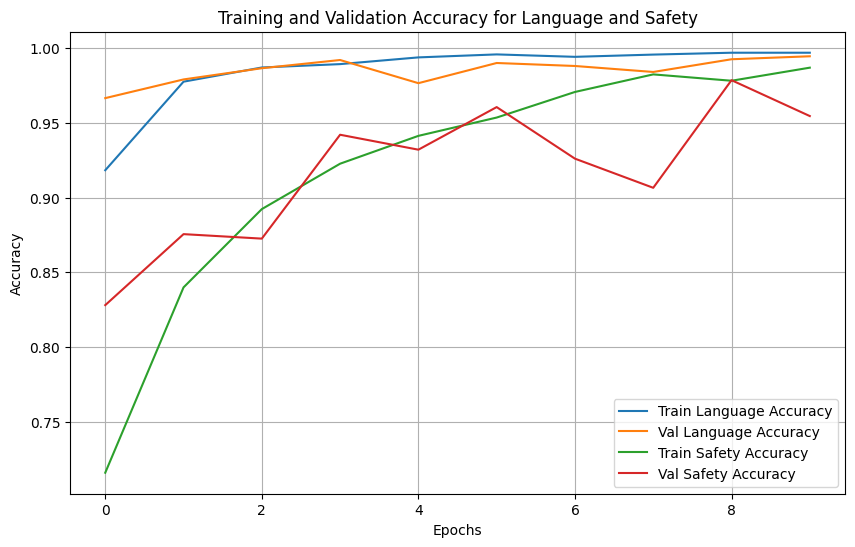

In [98]:
plt.figure(figsize=(10, 6))

# Language output accuracies
plt.plot(history.history['language_output_accuracy'], label='Train Language Accuracy')
plt.plot(history.history['val_language_output_accuracy'], label='Val Language Accuracy')

# Safety output accuracies
plt.plot(history.history['safety_output_accuracy'], label='Train Safety Accuracy')
plt.plot(history.history['val_safety_output_accuracy'], label='Val Safety Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Language and Safety')
plt.legend()
plt.grid(True)
plt.show()


In [99]:

# assume you already have `model` loaded & compiled

# 1) Load the same tokenizer you used in training
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")

# 2) Define some test snippets
TEST_SNIPPETS = [
    # a likely-vulnerable Python snippet (SQLi)
    """
import sqlite3
def get_user(username):
    conn = sqlite3.connect('users.db')
    c = conn.cursor()
    # vulnerable: string concatenation
    c.execute("SELECT * FROM users WHERE name = '" + username + "'")
    return c.fetchall()
""",
    # a safe Python snippet
    """
def safe_add(a, b):
    # uses parameter binding
    import sqlite3
    conn = sqlite3.connect('users.db')
    c = conn.cursor()
    c.execute("SELECT * FROM users WHERE name = ?", (a,))
    return c.fetchall()
""",
    # a Java example
    """
public class HelloWorld {
  public static void main(String[] args) {
    System.out.println("Hello, world!");
  }
}
""",
]

# 3) Tokenize in one batch (padding & truncation to max_length=512)
enc = tokenizer(
    TEST_SNIPPETS,
    padding="max_length",
    truncation=True,
    max_length=512,
    return_tensors="tf"
)

input_ids      = enc["input_ids"]      # shape (batch, 512)
attention_mask = enc["attention_mask"] # shape (batch, 512)

# 4) Call your model
lang_logits, safety_logits = model.predict([input_ids, attention_mask])

# 5) Convert to hard labels
lang_preds = np.argmax(lang_logits, axis=1)            # e.g. [3, 2, 1]
safety_preds = (safety_logits.flatten() > 0.5).astype(int)

# 6) Map your label IDs back to human names
LANG_ID2NAME = {
    0: "c",
    1: "java",
    2: "php",
    3: "python",
    4: "other",
}

# 7) Print results
for i, code in enumerate(TEST_SNIPPETS):
    lang_id  = lang_preds[i]
    saf_id   = safety_preds[i]
    lang_prob= float(lang_logits[i, lang_id])
    saf_prob = float(safety_logits[i])  # sigmoid→prob
    
    print(f"\n--- Sample #{i+1} ---")
    print(code.strip()[:200].replace("\n","⏎")+"…")  # first 200 chars
    print(f"→ Predicted language:   {LANG_ID2NAME[lang_id]}  (p={lang_prob:.2f})")
    print(f"→ Predicted vulnerability:  {'VULNERABLE' if saf_id else 'SAFE'}  (p={saf_prob:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

--- Sample #1 ---
import sqlite3⏎def get_user(username):⏎    conn = sqlite3.connect('users.db')⏎    c = conn.cursor()⏎    # vulnerable: string concatenation⏎    c.execute("SELECT * FROM users WHERE name = '" + username…
→ Predicted language:   python  (p=0.59)
→ Predicted vulnerability:  SAFE  (p=0.29)

--- Sample #2 ---
def safe_add(a, b):⏎    # uses parameter binding⏎    import sqlite3⏎    conn = sqlite3.connect('users.db')⏎    c = conn.cursor()⏎    c.execute("SELECT * FROM users WHERE name = ?", (a,))⏎    return c.…
→ Predicted language:   php  (p=0.58)
→ Predicted vulnerability:  SAFE  (p=0.03)

--- Sample #3 ---
public class HelloWorld {⏎  public static void main(String[] args) {⏎    System.out.println("Hello, world!");⏎  }⏎}…
→ Predicted language:   java  (p=1.00)
→ Predicted vulnerability:  VULNERABLE  (p=0.95)


<ipython-input-99-96f473d5015d>:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  saf_prob = float(safety_logits[i])  # sigmoid→prob


In [ ]:
# import tensorflow as tf
# from transformers import DistilBertTokenizer

# # Load the model with custom objects
# model = tf.keras.models.load_model(
#     'best_vulnerability_model.keras',
#     custom_objects={
#         'distilbert_lambda': distilbert_lambda,  # Your Lambda function
#         'Adam': tf.keras.optimizers.Adam  # Include if using a custom optimizer
#     }
# )

In [ ]:
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')  # Replace with your tokenizer

In [ ]:
# def preprocess_input(text, max_length=512):
#     # Tokenize the text
#     inputs = tokenizer(
#         text,
#         max_length=max_length,
#         padding='max_length',
#         truncation=True,
#         return_tensors='tf'  # Return TensorFlow tensors
#     )
#     return {
#         'input_ids': inputs['input_ids'],
#         'attention_mask': inputs['attention_mask']
#     }

In [ ]:
# def predict_vulnerability(text):
#     # Preprocess the input
#     inputs = preprocess_input(text)
    
#     # Get model prediction (probability between 0 and 1)
#     prediction = model.predict({
#         'input_ids': inputs['input_ids'],
#         'attention_mask': inputs['attention_mask']
#     })
    
#     # Convert probability to class (e.g., threshold=0.5)
#     class_label = "Vulnerable" if prediction[0][0] > 0.5 else "Safe"
#     confidence = prediction[0][0] * 100  # Confidence percentage
    
#     return {
#         "prediction": class_label,
#         "confidence": f"{confidence:.2f}%"
#     }
    

In [ ]:
# # Example usage
# user_input = """
# import sqlite3
# conn = sqlite3.connect('test.db')
# c = conn.cursor()
# username = input("Enter username: ")
# password = input("Enter password: ")
# c.execute("SELECT * FROM users WHERE username=? AND password=?", (username, password))
# """
# result = predict_vulnerability(user_input)
# print(f"Prediction: {result['prediction']} | Confidence: {result['confidence']}")

In [ ]:
# # Example usage
# user_input = """
# from owtf.plugin.helper import plugin_helper

# DESCRIPTION = "Plugin to assist manual testing"


# def run(PluginInfo):
#     Content = plugin_helper.HtmlString("Intended to show helpful info in the future")
#     return Content

# """
# result = predict_vulnerability(user_input)
# print(f"Prediction: {result['prediction']} | Confidence: {result['confidence']}")